In [1]:
import mat73
import pandas as pd
import numpy as np
import scipy.io
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

### Data loading and preprocessing

In [2]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()):
    if "anuja" in os.environ.get('USER'):
        DATA_DIR = 'data/'
    elif 'ubuntu' in os.environ.get('USER'):
        DATA_DIR = '/home/ubuntu/Martyna/repo/AI4Health/DATAfoof/'
    

In [3]:
# foof = pd.read_csv(DATA_DIR+"sensor_intercept_slope.csv")
# #foof = foof.rename(columns={"C1": "IDs" ,"C2": "Intercept", "C3": "Slope"})
# foof

In [4]:
# data = scipy.io.loadmat(DATA_DIR+'x.mat')  
# df = pd.DataFrame(data['x'].reshape((data['x'].shape[0], -1)))

# # sparsing
# df = np.array(df).reshape(data['x'].shape)
# df_sparsed = np.concatenate([np.expand_dims(df[:,:,i:i+2].mean(axis = 2), axis = 2) for i in range(0, data['x'].shape[2]-2, 2)], axis = 2)
# df = pd.DataFrame(df_sparsed.reshape((df_sparsed.shape[0], -1)))

# #scaling
# norm = MinMaxScaler().fit(df)
# df = norm.transform(df)
# df = pd.DataFrame(df.reshape((df.shape[0], -1)))

# columns = np.asarray([['Electrode %d - %d/2 Hz'%(i+1, j+1)] for i in range(df_sparsed.shape[1]) for j in range(df_sparsed.shape[2])])
# df.columns = columns
# df['IDs'] = foof['IDs']
# df

In [5]:
# beh = pd.read_csv(DATA_DIR+"behaviorals.csv")
# print('Before:'+str(beh.shape))

# most_common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
#                          'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
#                          'Depressive Disorders',  'No Diagnosis Given', 'Other Disorders']

# category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)] +\
#                    ['DX_' + str(i).zfill(2) + '_Sub' for i in range(1, 11)]

# # removing patients with incomplete eval
# initial_size = beh.shape[0]
# beh = beh[beh.DX_01 != 'No Diagnosis Given: Incomplete Eval']
# beh = beh.reset_index(drop=True)
# new_size = beh.shape[0]

# print('After:'+str(beh.shape))
# print('Removing', initial_size - new_size,
#       'patients as their evaluations was incomplete.')

In [6]:
# no_diagnosis_given = 'No Diagnosis Given'

# diagnoses_to_ids = {disorder: i for i, disorder in enumerate(most_common_disorders)}
# diagnoses_to_ids

In [7]:
# def get_disorder(data, row, index):
#     disorder = data.iloc[row][category_columns[index]]

#     if disorder == 'Neurodevelopmental Disorders':
#         disorder = data.iloc[row][category_columns[index + 10]]

#     return disorder

# order_of_disorders = []
# for k in range(beh.shape[0]):
#     i = 0
#     disorder = get_disorder(beh, k, i)
#     disorders_patient = []
#     while not pd.isnull(disorder):
#         if disorder in diagnoses_to_ids:
#             if diagnoses_to_ids[disorder] not in disorders_patient:
#                 disorders_patient.append(diagnoses_to_ids[disorder])
#         else:
#             if diagnoses_to_ids['Other Disorders'] not in disorders_patient:
#                 disorders_patient.append(diagnoses_to_ids['Other Disorders'])
#         i += 1
#         if i == len(category_columns):
#             break
#         disorder = get_disorder(beh, k, i)

        
#     order_of_disorders.append(disorders_patient)

In [8]:
# other_disorders = []
# no_diagnosis_given = []
# for i in order_of_disorders:
#     if 7 in i:
#         no_diagnosis_given.append(1)
#         i.remove(7)
#     else:
#         no_diagnosis_given.append(0)
#     if 8 in i:
#         other_disorders.append(1)
#         i.remove(8)
#     else:
#         other_disorders.append(0)

In [9]:
# max_len_order = np.max([len(x) for x in order_of_disorders])

# # pad with a new token denoting the pad token
# pad_token = len(most_common_disorders)
# bod_token = len(most_common_disorders) + 1
# eod_token = len(most_common_disorders) + 2

# order_of_disorders = [[bod_token] + x + [eod_token] + [pad_token] * (max_len_order - len(x)) for x in order_of_disorders]

# order_of_disorders = np.array(order_of_disorders)

# classes = np.zeros((len(most_common_disorders),
#                     beh.shape[0]), dtype=np.int32)

# df_disorders = beh[category_columns]

# for i, disorder in enumerate(most_common_disorders):
#     mask = df_disorders.select_dtypes(include=[object]). \
#         applymap(lambda x: disorder in x if pd.notnull(x) else False)

#     disorder_df = df_disorders[mask.any(axis=1)]

#     np.add.at(classes[i], disorder_df.index.values, 1)

# behaviour_data_columns = beh.columns.values.astype(np.str)

# columns_to_drop = behaviour_data_columns[
#     np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX') != -1)]

# behaviour_data = beh.drop(columns=columns_to_drop)

# for disorder, classification in zip(most_common_disorders, classes):
#     behaviour_data[disorder] = classification

# behaviour_data['order_diagnoses'] = list(order_of_disorders)

In [10]:
# common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
#                          'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
#                          'Depressive Disorders']

# labels=behaviour_data[["IDs"]+list(common_disorders)]
# labels["Other Disorders"] = other_disorders
# labels

In [11]:
# df = pd.merge(df, foof, on='IDs', how='inner')
# df = pd.merge(df, labels, on='IDs', how='inner')
# df

### Data Split

In [12]:
# disorders_list = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
#                          'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
#                          'Depressive Disorders', 'Other Disorders']
# x = df[df.columns.difference(['IDs']+disorders_list)]
# y = df[disorders_list]

# # summarize dataset shape
# print(x.shape, y.shape)

# train_features, test_features, train_labels, test_labels = train_test_split(x, y, test_size=0.25, shuffle=True)

In [13]:
# path = os.path.join(DATA_DIR, 'multilabel_classification_sensor_level')
path = os.path.join(DATA_DIR, 'multilabel_classification_sensor_level_age_gender')

# #saving
# if not(os.path.exists(path)):
#     os.mkdir(path)
# np.save(os.path.join(path, 'train_features.npy'), train_features)
# np.save(os.path.join(path, 'test_features.npy'), test_features)
# np.save(os.path.join(path, 'train_labels.npy'), train_labels)
# np.save(os.path.join(path, 'test_labels.npy'), test_labels)

In [14]:
#loading
train_features = np.load(os.path.join(path, 'train_features.npy'))
test_features = np.load(os.path.join(path, 'test_features.npy'))
train_labels = np.load(os.path.join(path, 'train_labels.npy'))
test_labels = np.load(os.path.join(path, 'test_labels.npy'))

In [15]:
train_labels = np.array(train_labels) 
test_labels = np.array(test_labels) 

## FEATURE EXTRACTION WITH PCA

In [16]:
age_gender = True
if age_gender:
    train_age_gender = train_features[:,-2:]
    test_age_gender = test_features[:,-2:]
    train_features = train_features[:,:-2]
    test_features = test_features[:,:-2]

In [17]:
#scaling features

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
train_features = norm.transform(train_features)
test_features = norm.transform(test_features)

print(train_features.shape, test_features.shape)

(1440, 4305) (481, 4305)


In [18]:
# dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(.95) # 95% variance retained
pca.fit(train_features)

# transform data
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
print(train_features.shape, test_features.shape)

(1440, 237) (481, 237)


In [19]:
if age_gender:
    train_features = np.concatenate([train_features, train_age_gender], axis = 1)
    test_features = np.concatenate([test_features, test_age_gender], axis = 1)

## FEATURE EXTRACTION WITH AUTOENCODER

In [20]:
# import tensorflow as tf
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
# from tensorflow.keras.utils import plot_model, to_categorical

# n_inputs = train_features.shape[1]

# visible = Input(shape=(n_inputs,))
# e = Dense(n_inputs*2)(visible)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# e = Dense(n_inputs)(e)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# n_bottleneck = round(float(n_inputs) / 2.0)
# bottleneck = Dense(n_bottleneck)(e)

# d = Dense(n_inputs)(bottleneck)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# d = Dense(n_inputs*2)(d)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# output = Dense(8, activation='linear')(d)

# model = Model(inputs=visible, outputs=output)
# model.compile(optimizer='adam', loss='mse')
# plot_model(model, 'autoencoder_compress.png', show_shapes=True)

# history = model.fit(train_features, train_labels, epochs=50, batch_size=16, verbose=2)
# encoder = Model(inputs=visible, outputs=bottleneck)

# plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# encoder.save('autoencoder.h5')

In [21]:
# # encode the data
# encoder= load_model('autoencoder.h5', compile=False)

# train_features = encoder.predict(train_features)
# test_features = encoder.predict(test_features)

### Metrics

In [45]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

n_classes = train_labels.shape[1]

def plot_pr_curve(Y_test, y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict() #actually stores AUC
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
        average_precision[i] = auc(recall[i], precision[i])
#         average_precision[i] = auc(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y_test.ravel(), y_score.ravel()
    )
#     average_precision["macro"] = auc(recall["micro"], precision["micro"])
    average_precision["macro"] = np.average(list(average_precision.values()))

    _, ax = plt.subplots(figsize=(8, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["macro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(n_classes):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall curve")
    plt.show()
    
    return average_precision["macro"]
    
def plot_roc_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
#     fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["macro"] = np.average(list(roc_auc.values()))
    
    # Plot ROC curve
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operator characteristics')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc["macro"]

In [23]:
from sklearn.metrics import hamming_loss, accuracy_score
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

def evaluate(y_test, y_pred_prob, brier=True):
    y_pred = y_pred_prob.round()
    accuracy = accuracy_score(y_test, y_pred)
    hamming = hamming_loss(y_test, y_pred)
    brier_score = brier_multi(y_test, y_pred_prob)
    report = skm.classification_report(y_test,y_pred, zero_division=1, output_dict=True)
    
    print("Accuracy:", accuracy)
    print("Hamming Loss:", hamming)
    if brier:
        print("Brier Score:", brier_score)
    print("Classification Report:\n", skm.classification_report(y_test,y_pred, zero_division=1))
    print("Confusion matrix:\n", skm.multilabel_confusion_matrix(y_test, y_pred))
    
    return accuracy,  hamming, brier_score, report

## Models

In [42]:
model_names, model_names_all = [], []
accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc = [], [], [], [], [], [], [], []
accuracy_scores_all, hamming_all, brier_score_all, precision_all, recall_all, f1_score_all, pr_auc_all, roc_auc_all = [], [], [], [], [], [], [], []
accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std = [], [], [], [], [], [], [], []

def record_values(a, h, b, p, r, f, pr, roc,a_std, h_std, b_std, p_std, r_std, f_std, pr_std, roc_std, model_name=''):
    accuracy_scores.append(a)
    hamming.append(h)
    brier_score.append(b)
    precision.append(p)
    recall.append(r)
    f1_score.append(f)
    pr_auc.append(pr)
    roc_auc.append(roc)
    
    accuracy_scores_std.append(a_std)
    hamming_std.append(h_std)
    brier_score_std.append(b_std)
    precision_std.append(p_std)
    recall_std.append(r_std)
    f1_score_std.append(f_std)
    pr_auc_std.append(pr_std)
    roc_auc_std.append(roc_std)
    model_names.append(model_name)

def record_values_all(a, h, b, p, r, f, pr, roc, model_name=''):
    accuracy_scores_all.append(a)
    hamming_all.append(h)
    brier_score_all.append(b)
    precision_all.append(p)
    recall_all.append(r)
    f1_score_all.append(f)
    pr_auc_all.append(pr)
    roc_auc_all.append(roc)
    model_names_all.append(model_name)

In [25]:
def ci(vals):
    return np.percentile(vals, 5), np.percentile(vals, 95)

In [26]:
# specify runs here
n = 4

### Random Baseline

#### mit shuffling

In [47]:
%%capture

import sys, os

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    predicted_labels_shuffled = np.copy(test_labels)
    np.random.shuffle(predicted_labels_shuffled)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_shuffled)
    pr = plot_pr_curve(test_labels, predicted_labels_shuffled)
    roc = plot_roc_curve(test_labels, predicted_labels_shuffled)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Shuffling Baseline')
    

vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Shuffling Baseline')

Accuracy: 0.0498960498960499
Hamming Loss: 0.32588357588357586
Brier Score: 2.607068607068607
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.65      0.65       300
           1       0.30      0.30      0.30       140
           2       0.23      0.23      0.23       111
           3       0.13      0.13      0.13        68
           4       0.19      0.19      0.19        70
           5       0.16      0.16      0.16        80
           6       0.13      0.13      0.13        47
           7       0.41      0.41      0.41       192

   micro avg       0.38      0.38      0.38      1008
   macro avg       0.27      0.27      0.27      1008
weighted avg       0.38      0.38      0.38      1008
 samples avg       0.44      0.45      0.33      1008

Confusion matrix:
 [[[ 75 106]
  [106 194]]

 [[243  98]
  [ 98  42]]

 [[284  86]
  [ 86  25]]

 [[354  59]
  [ 59   9]]

 [[354  57]
  [ 57  13]]

 [[334  67]
  [ 67  13]]

 [

TypeError: unsupported operand type(s) for /: 'dict_values' and 'int'

#### dummy classifiers

%%capture

from sklearn.dummy import DummyClassifier

n=10
strategies = ['stratified', 'most_frequent', 'uniform']

for strategy_ in strategies:

    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)


strategies = ['stratified', 'most_frequent', 'uniform']

for strategy_ in strategies:

    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)



    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)



    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)


### Multi Output Classifier

In [28]:
%%capture

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

forest = RandomForestClassifier()
lg = LogisticRegression()
models = [lg, forest]

number_of_bootstraps = 10
seed_value = 7

for model in models:
    
    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []
    for i in range(n):

        multi_output_model = MultiOutputClassifier(model, n_jobs=-1)
        multi_output_model.fit(train_features, train_labels)

        # Boostrap
        resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

        predicted_labels = np.asarray(multi_output_model.predict_proba(resampled_xtest))[:, :, 1].T
        print(str(model)+':')
        accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels)
        pr = plot_pr_curve(resampled_ytest, predicted_labels)
        roc = plot_roc_curve(resampled_ytest, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)
        record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Multi Output Classifier-'+str(model))
    
    
    vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
    means = [np.mean(v) for v in vals]
    cis = [ci(v) for v in vals]
    record_values(*means, *cis, 'Multi Output Classifier-'+str(model))

In [29]:
print(np.mean(a_avg), np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg), np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg))
accuracy_scores

0.1257796257796258 0.23707120582120583 1.3751432432432433 0.6092545761495718 0.28083227683958745 0.3843545092044519 0.4828464341125249 0.7094503002121934 0.017671517671517672 0.006123289269388642 0.0065209646125369315 0.03463023091621382 0.007776248888311879 0.013935574640676759 0.01806791227984596 0.00433601345009587


[0.04573804573804574, 0.08991683991683992, 0.1257796257796258]

## MLP SIMPLE

In [30]:
%%capture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
    mlp = get_mlp(n_inputs, n_outputs)
    mlp.fit(train_features, train_labels, verbose=0, epochs=100)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    predicted_labels_mlp = mlp.predict(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_mlp)

    pr = plot_pr_curve(resampled_ytest, predicted_labels_mlp)
    roc = plot_roc_curve(resampled_ytest, predicted_labels_mlp)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MLP-1L')

    
    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'MLP-1L')

## MLP complex

In [31]:
%%capture


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))

    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
    mlp = get_mlp(n_inputs, n_outputs)
    mlp.fit(train_features, train_labels, verbose=0, epochs=100)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    predicted_labels_mlp = mlp.predict(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_mlp)

    pr = plot_pr_curve(resampled_ytest, predicted_labels_mlp)
    roc = plot_roc_curve(resampled_ytest, predicted_labels_mlp)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MLP-compl')


vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'MLP-compl')

### Binary Relevance
ignores the possible correlations between class labels

In [32]:
%%capture

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB


a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = BinaryRelevance(GaussianNB())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)


    predicted_labels_br = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_br.toarray())
    
    pr = plot_pr_curve(resampled_ytest, predicted_labels_br.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_br.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Binary relevance')


vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Binary relevance')

### Classfier Chains

In [33]:
%%capture



from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = ClassifierChain(LogisticRegression())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    predicted_labels_cc = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_cc.toarray())
    pr = plot_pr_curve(resampled_ytest, predicted_labels_cc.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_cc.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Classifier Chains')


vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Classifier Chains')

### Label Powerset
takes correlations into account!

In [34]:
%%capture

from skmultilearn.problem_transform import LabelPowerset

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = LabelPowerset(LogisticRegression())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    
    predicted_labels_lp = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_lp.toarray())
    pr = plot_pr_curve(resampled_ytest, predicted_labels_lp.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Label Powerset-LR')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Label Powerset-LR')

KeyboardInterrupt: 

In [35]:
%%capture

from sklearn.ensemble import RandomForestClassifier

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):

    classifier = LabelPowerset(RandomForestClassifier())
    classifier.fit(train_features, train_labels)

    predicted_labels_lp = classifier.predict_proba(test_features)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_lp.toarray())
    pr = plot_pr_curve(test_labels, predicted_labels_lp.toarray())
    roc = plot_roc_curve(test_labels, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Label Powerset-RFC')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Label Powerset-RFC')

In [36]:
print(np.mean(a_avg), np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg),np.std(a_avg), np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg))

0.12785862785862787 0.23115904365904366 1.3347095634095634 0.6249270222660369 0.2941468253968254 0.40000246864816824 0.49812362067547133 0.7231948112284821 0.0023243949870060186 0.0011837881469782114 0.005182509865350755 0.0060235263593143495 0.0011091607031248917 0.0015660310045267822 0.007130132053407465 0.00280132641970311


### Visualisation

In [37]:
%matplotlib inline

[0.04573804573804574, 0.08991683991683992, 0.1257796257796258, 0.07744282744282745, 0.05301455301455302, 0.059251559251559255, 0.10446985446985448, 0.12785862785862787] [(0.042203742203742206, 0.04781704781704782), (0.06902286902286903, 0.10717255717255718), (0.11257796257796258, 0.15062370062370062), (0.06923076923076923, 0.09074844074844075), (0.030145530145530147, 0.07006237006237007), (0.04906444906444907, 0.06943866943866944), (0.0971933471933472, 0.10810810810810811), (0.12505197505197507, 0.13066528066528066)]


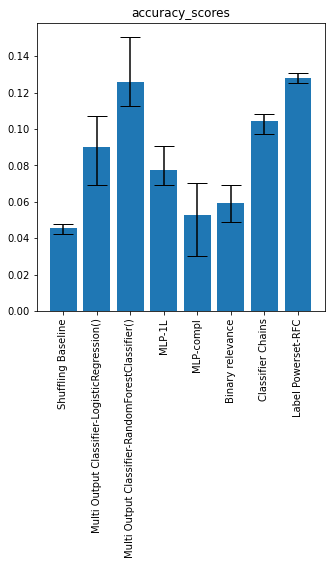

[0.3332900207900208, 0.2658523908523908, 0.23707120582120583, 0.29489345114345117, 0.3160732848232848, 0.2924246361746362, 0.2704002079002079, 0.23115904365904366] [(0.3268191268191268, 0.3406704781704782), (0.26157744282744283, 0.27030925155925156), (0.22917099792099793, 0.2437889812889813), (0.2894360706860707, 0.3038981288981289), (0.3076793139293139, 0.3309251559251559), (0.2889163201663202, 0.2962058212058212), (0.26582640332640334, 0.27315488565488566), (0.22952182952182953, 0.23225051975051975)]


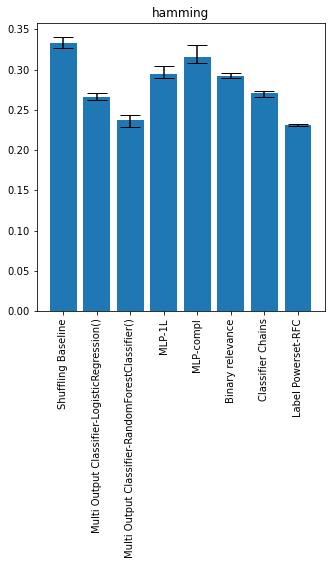

[2.6663201663201663, 1.5025329727685501, 1.3751432432432433, 1.946731246303952, 2.2395757650436776, 1.8338683646203775, 1.5616296905169809, 1.3347095634095634] [(2.6145530145530143, 2.7253638253638255), (1.4880137698752982, 1.5177882002272751), (1.368691029106029, 1.383794417879418), (1.9187755714819505, 1.9642757558381425), (2.1804071780078313, 2.332187543875636), (1.8164119171210718, 1.8512767823814955), (1.5441023536907996, 1.584442280920134), (1.3274862993762995, 1.3391767775467776)]


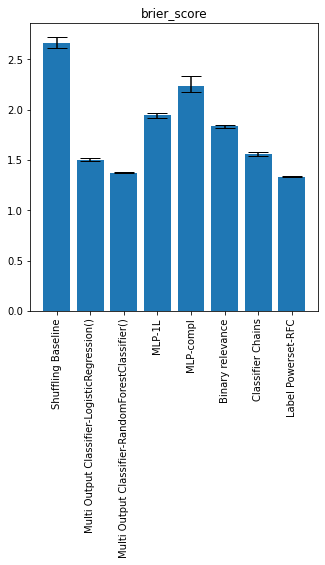

[0.3638392857142857, 0.49301769355265435, 0.6092545761495718, 0.4294535124511145, 0.3993738993707011, 0.4245023442087983, 0.48013708785526815, 0.6249270222660369] [(0.3497519841269841, 0.3761904761904762), (0.48694633456011605, 0.5023780487804878), (0.5615520175012154, 0.6408214697960753), (0.4032094297786889, 0.44555105870107103), (0.36746028969281364, 0.42087622360926363), (0.4166959406713505, 0.42980133005008625), (0.46801634156603317, 0.4885400919984689), (0.6188731025789169, 0.6330939629990263)]


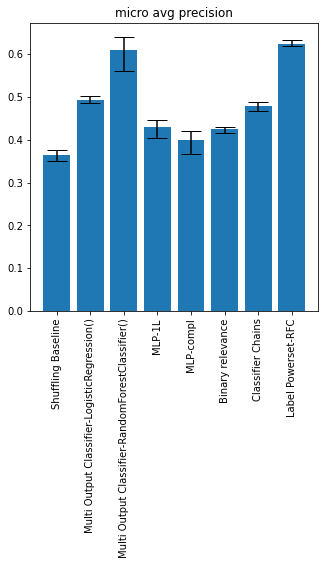

[0.3638392857142857, 0.3254783542888441, 0.28083227683958745, 0.3602101659354766, 0.3936066936272183, 0.30922965626727067, 0.3193257350568433, 0.2941468253968254] [(0.3497519841269841, 0.3761904761904762), (0.3190672497274418, 0.3326715100065229), (0.2705763584403382, 0.28881535519115104), (0.34494033781183864, 0.3688747979315756), (0.3669256968368306, 0.41581615467854993), (0.30664891951143125, 0.31219760308644723), (0.3140865492528699, 0.32300446204895017), (0.2928075396825397, 0.2954861111111111)]


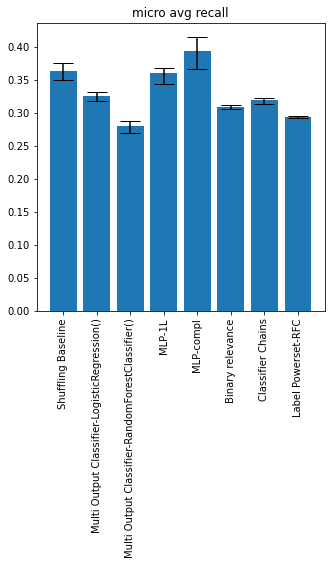

[0.3638392857142857, 0.3920983489617937, 0.3843545092044519, 0.3915528093184524, 0.3961014997920748, 0.3577974802008265, 0.3835537744529255, 0.40000246864816824] [(0.3497519841269841, 0.3761904761904762), (0.38553958177744585, 0.40026244053280147), (0.3653055601025809, 0.3979830462531726), (0.37952958786829094, 0.40360222696043596), (0.3733712221367562, 0.41832296704038413), (0.3535880153943725, 0.3600053337557237), (0.3759027473559047, 0.38888962735434396), (0.3983130904183536, 0.4020731707317073)]


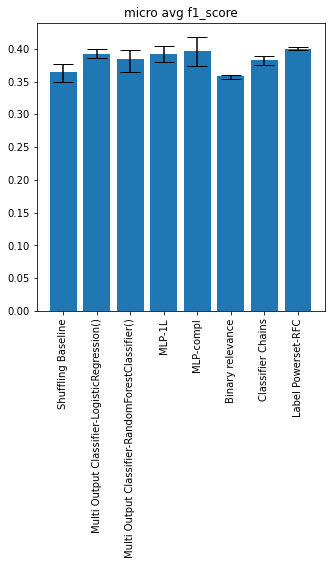

[0.4471617909117909, 0.4370839341620991, 0.4828464341125249, 0.3918031838398295, 0.3821529669253025, 0.3620905658285525, 0.41657174832258204, 0.49812362067547133] [(0.4349196036696037, 0.4578952578952579), (0.42738508582733375, 0.4491865745545635), (0.45764342687891796, 0.49724378727242163), (0.37484352261598447, 0.4035536270929673), (0.3709843958356741, 0.38923715314431656), (0.353655037838652, 0.3670681306019103), (0.40280201570292057, 0.4309917527523038), (0.48943939892304744, 0.5064902282571446)]


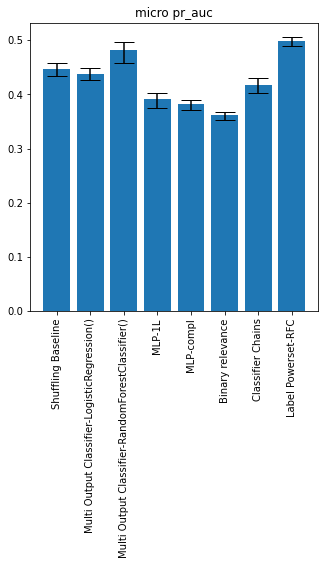

[0.5690235160965795, 0.693538206234364, 0.7094503002121934, 0.6534184714933569, 0.6246421481923754, 0.6432052846825409, 0.6797788294960209, 0.7231948112284821] [(0.5594798653029286, 0.5773910127431254), (0.6878201367171398, 0.6980275911903957), (0.7061673885983261, 0.7155188844125873), (0.649363657573862, 0.6580495715087397), (0.607345220498576, 0.6363940623543102), (0.6385606462377684, 0.6461762948301383), (0.6721850522506388, 0.6847558377919648), (0.7210551590794769, 0.7270861016795216)]


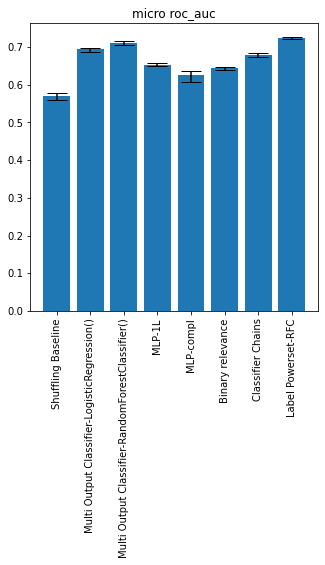

In [38]:
import matplotlib.pyplot as plt

score_names = ['accuracy_scores', 'hamming', 'brier_score', 'micro avg precision', 'micro avg recall', 'micro avg f1_score', 'micro pr_auc', 'micro roc_auc']
for scores, scores_std, score_name in zip([accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc],[accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std], score_names):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes([0,0,1,1])
    print(scores, scores_std)
    scores_std = np.array(list(zip(*scores_std)))
    scores_std[0] = scores - scores_std[0]
    scores_std[1] = scores_std[1] - scores
    ax.bar(model_names, scores, yerr = scores_std, capsize=10)
    plt.xticks(rotation='vertical')
    plt.title(score_name)
    plt.show()


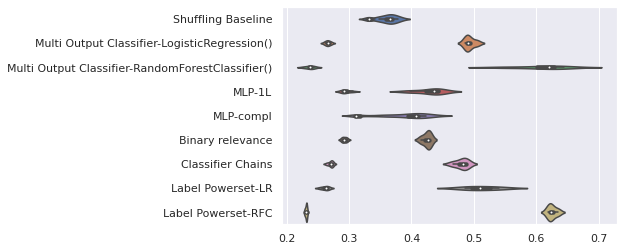

In [39]:
import seaborn as sns
df = sns.load_dataset('iris')
sns.set(style="darkgrid")

# plot
sns.violinplot(x=hamming_all, y=model_names_all)
sns.violinplot(x=precision_all, y=model_names_all)
# sns.set(rc = {'figure.figsize':(25,10)})
plt.show()

In [40]:
accuracy_scores_all

[0.04781704781704782,
 0.04781704781704782,
 0.04573804573804574,
 0.04158004158004158,
 0.06652806652806653,
 0.10187110187110188,
 0.10810810810810811,
 0.08316008316008316,
 0.11434511434511435,
 0.12058212058212059,
 0.15592515592515593,
 0.11226611226611227,
 0.09355509355509356,
 0.07276507276507277,
 0.07484407484407485,
 0.06860706860706861,
 0.04781704781704782,
 0.07068607068607069,
 0.06652806652806653,
 0.02702702702702703,
 0.056133056133056136,
 0.04781704781704782,
 0.07068607068607069,
 0.062370062370062374,
 0.09563409563409564,
 0.10810810810810811,
 0.10602910602910603,
 0.10810810810810811,
 0.08731808731808732,
 0.08316008316008316,
 0.079002079002079,
 0.12474012474012475,
 0.12681912681912683,
 0.13097713097713098,
 0.1288981288981289]